# Symmetric QNN

In [114]:
import numpy as np
import pennylane as qml
import jax
import optax
import jax.numpy as jnp
import matplotlib.pyplot as plt

## Create dataset

In [115]:
# helper function to determine valid tic tac toe board positions
def get_winner(board):
        # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                return [0,0,1]
            else:
                return [1,0,0]
    return [0,1,0]
    

def is_valid_tic_tac_toe(board):
    # Check that the board has exactly 9 elements
    if len(board) != 9:
        return False
    
    # Count the number of 'x' and 'o' on the board
    count_x = board.count('x')
    count_o = board.count('o')
    
    # Check that the difference in count between 'x' and 'o' is 0 or 1
    if abs(count_x - count_o) > 1:
        return False
    
    # Check the board for any winning combinations
    winning_combinations = [
        # Rows
        (0, 1, 2),
        (3, 4, 5),
        (6, 7, 8),
        # Columns
        (0, 3, 6),
        (1, 4, 7),
        (2, 5, 8),
        # Diagonals
        (0, 4, 8),
        (2, 4, 6),
    ]
    
    x_wins = False
    o_wins = False
    
    for combo in winning_combinations:
        if board[combo[0]] == board[combo[1]] == board[combo[2]] and board[combo[0]] != '':
            if board[combo[0]] == 'x':
                x_wins = True
            else:
                o_wins = True
    
    # Check if both 'x' and 'o' won or if neither won
    if x_wins and o_wins or (not x_wins and not o_wins):
        return False
    
    # Check that the board is a valid final board configuration
    if (x_wins and count_x != count_o + 1) or (o_wins and count_x != count_o):
        return False
    # All checks have passed, so the board is valid
    return True
  

In [116]:
def generate_tic_tac_toe_configs():
    valid_configs = []
    winners = []
    
    # Generate all possible configurations of the board
    for i in range(3**9):
        board = []
        for j in range(9):
            symbol = ''
            if i % 3 == 0:
                symbol = 'x'
            elif i % 3 == 1:
                symbol = 'o'
            board.append(symbol)
            i //= 3
        
        # Check if the configuration is valid
        if is_valid_tic_tac_toe(board):
            valid_configs.append(board)
            winners.append(get_winner(board))
    
    return valid_configs, winners

In [117]:
boards, winners = generate_tic_tac_toe_configs()
print("boards: ", boards[1:5])
print("winners: ",  winners[1:5])
print(len(boards))
print(len(winners))

boards:  [['o', 'x', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['x', 'o', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', '', 'o', 'o', 'o', 'x', 'x', 'x', 'x'], ['', 'o', '', 'o', 'o', 'x', 'x', 'x', 'x']]
winners:  [[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]]
942
942


In [126]:
#Split data into test and train data
x = boards
y = winners

# shuffle the indices
shuffle_indices = np.random.permutation(len(x))
train_size = int(len(x) * 0.6)

# split the indices into training and testing sets
train_indices = np.array(shuffle_indices[:train_size])
test_indices = np.array(shuffle_indices[train_size:])

# create the training and testing sets
x_train, y_train = np.take(x, train_indices, axis=0), np.take(y, train_indices, axis=0)
x_test, y_test = np.take(x, test_indices, axis=0), np.take(y, test_indices, axis=0)


x_train = jnp.array(list(map(lambda x:  [1 if entry == 'x' else -1 if entry == 'o' else 0 for entry in x ], x_train)))
x_test = jnp.array(list(map(lambda x:  [1 if entry == 'x' else -1 if entry == 'o' else 0 for entry in x ], x_test)))

for i in range(5):
    print("Example train data: ", x_train[i], y_train[i])
    ###THERE ARE NO DRAWS!!!!!

Example train data:  [ 0 -1  1  1 -1  1 -1  0  1] [0 0 1]
Example train data:  [ 0  1  1  0  1 -1 -1  1 -1] [0 0 1]
Example train data:  [ 0  1 -1 -1  1  0  1  1 -1] [0 0 1]
Example train data:  [-1  1  1  1  1 -1 -1  1 -1] [0 0 1]
Example train data:  [-1  1  0 -1  1  1 -1  0  0] [1 0 0]


## Building the circuit

### Encoding the data

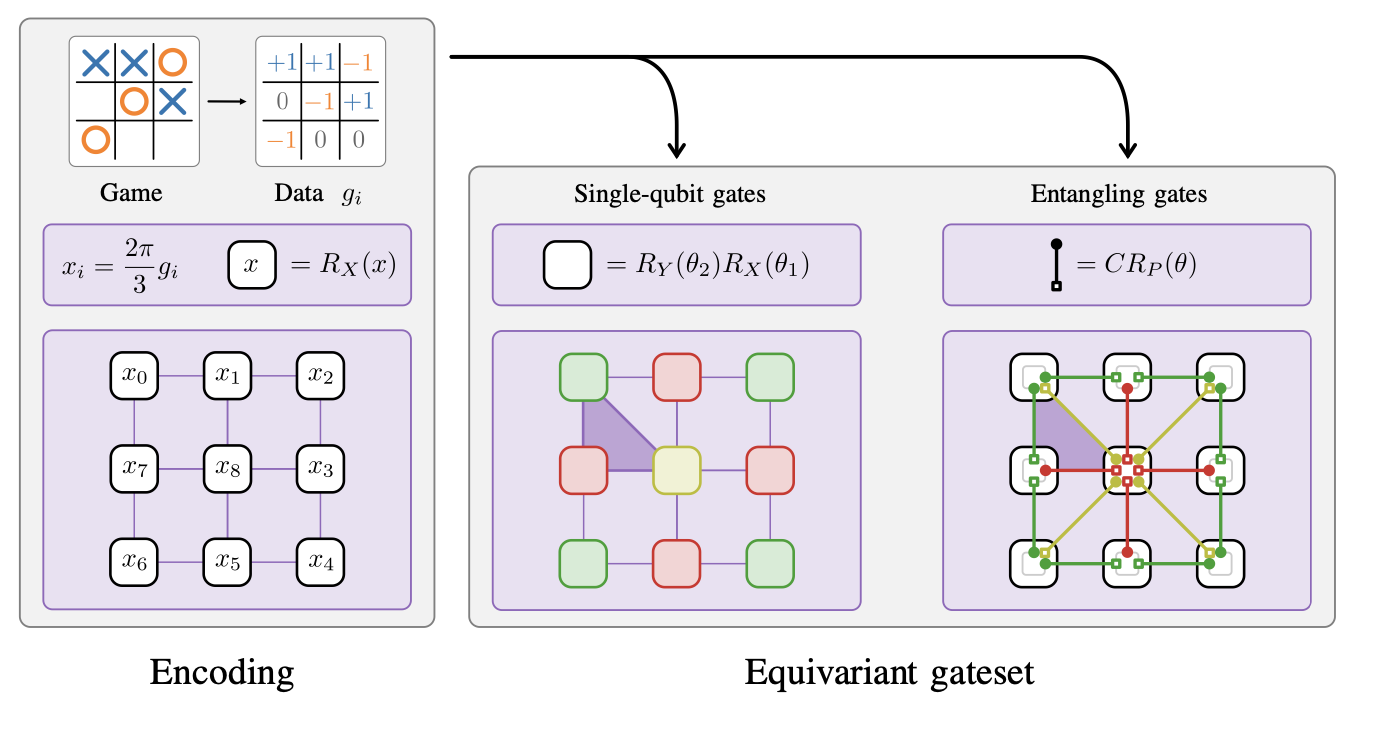

In [119]:
# tic_tac_toe_field = ['x','x','o','','o','x','o','','']
def encode_symm_data(data_g):
    ''' 
    Apply encoding RX rotation to the qubits
    '''
    for entry, index in zip(data_g, range(len(data_g))):
        qml.RX(entry * 2 * np.pi / 3, wires=index)

def symmetric_ansatz(thetas,):
    ''' 
    Creation of full symmetric ansatz from the layers of embedding and Parametrized quantum circuit
    '''
    k = 0
    for lay in range(sublayers):
        symmetric_ansatz_layer(thetas[k:params_per_sublayer+k])
        k += params_per_sublayer

def symmetric_ansatz_layer(thetas):
    ''' 
    Single layer of the ansatz contained the parametrized quantum gates
    '''
    corner_qubits = [0,2,6,8]
    edge_qubits = [1,3,5,7]
    center_qubit = 4
    

    # symmetrization is obtained by the same parameters 
    # for all the rotations on each qubit
    k=0
    for c in corner_qubits:
        qml.RX(thetas[0], wires=c)
        qml.RY(thetas[1], wires=c)
    k+=2

    for e in edge_qubits:
        qml.RX(thetas[2], wires=e)
        qml.RY(thetas[3], wires=e)
    k+=2
    
    qml.RX(thetas[4], wires=center_qubit)
    qml.RY(thetas[5], wires=center_qubit)
    k+=2
    #k=6

    qml.Barrier(wires=range(n_qubits),only_visual=True)

    #symmetrization is obtained by the same parameters 
    # for all the entangling operationsof the same kind
    
    #corner center
    c_e = [(0,1), (0,3), (2,1), (2,5), (6,3), (6,7), (8,5), (8,7)]
    for c, e in c_e:
        qml.CRY(thetas[k], wires=[c,e])#qui tutti thetas uguali
    k+=1
    #k=7
    qml.Barrier(wires=range(n_qubits),only_visual=True)


    #edge center
    for e in edge_qubits:
        qml.CRY(thetas[k], wires=[e,center_qubit])
    k +=1
    # k=8
    qml.Barrier(wires=range(n_qubits),only_visual=True)

    #center corner
    for c in corner_qubits:
        qml.CRY(thetas[k], wires=[center_qubit,c])
    # k=8   
    
def symmetry_output(wires):
    ''' 
    Measurements to be performed on PQC
    '''
    op_circ = qml.expval(qml.PauliZ(wires=0)@ qml.PauliZ(wires=2)@qml.PauliZ(wires=6)@ qml.PauliZ(wires=8))
    op_tie = qml.expval(qml.PauliZ(wires=4))
    op_cross = qml.expval(qml.PauliZ(wires=1)@ qml.PauliZ(wires=3)@qml.PauliZ(wires=5)@ qml.PauliZ(wires=7))
    
    return op_circ, op_tie, op_cross,  

In [120]:
n_qubits = 9
device = qml.device("default.qubit.jax", wires=n_qubits)
    
@qml.qnode(device,interface='jax')#, diff_method='adjoint') 
def circuit_symmetric(x, thetas,):
    j = 0
    for lay in range(layers):
        encode_symm_data(x)
        qml.Barrier(wires=range(n_qubits),only_visual=True)
        
        symmetric_ansatz(thetas[j:j+(params_per_sublayer)*sublayers],)
        j += (params_per_sublayer)*sublayers
        #symmetry_ansatz(thetas)
    qml.Barrier(wires=range(n_qubits),only_visual=True)

    return symmetry_output(wires=range(n_qubits))

Let's see one layer of our QNN:

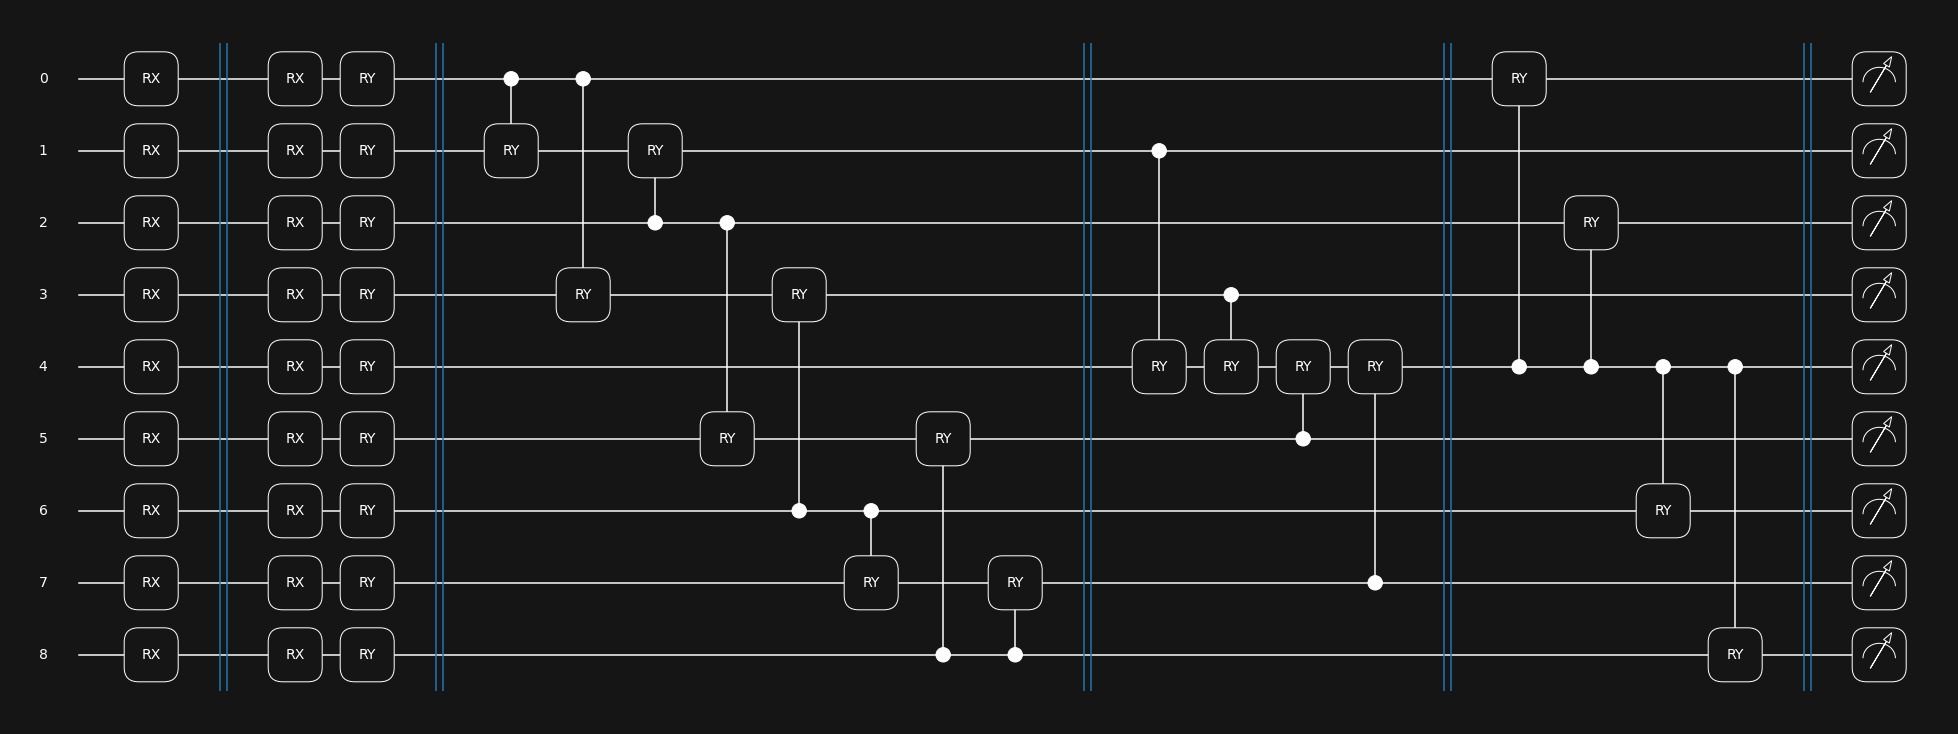

In [127]:
layers = 1
sublayers = 1
params_per_sublayer = 9
qml.draw_mpl(circuit_symmetric, style='black_white_dark')(x_train[0].tolist(), np.arange((params_per_sublayer )*layers*sublayers))#decimals=2,decimals=2,
plt.savefig('./symmetric_circuit.pdf')

### Cost function and update optimizer

In [122]:
@jax.jit
def calculate_mse_cost(X, y, theta,):
    y = jnp.array(y)
    # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # plt.show()
    yp = qnn(X, theta,) 
    yp=yp.at[:,:].multiply(.25)

    cost = jnp.mean((yp - y) ** 2)
    
    return cost

@jax.jit
def calculate_mse_cost_and_accuracy(x,y, opt_params):
    y = jnp.array(y)
    # qml.draw_mpl(circuit, decimals=2,expansion_strategy="device")(X[0].tolist(), theta)
    # plt.show()
    yp = qnn(x, opt_params,) 
    yp=yp.at[:,:].multiply(.25)

    cost = jnp.mean((yp - y) ** 2)
    max_idx_p = np.argmax(yp, axis=1)
    max_idx = np.argmax(y, axis=1)
    return cost, sum(max_idx_p==max_idx)/x.shape[0]

# Optimization update step
@jax.jit
def optimizer_update(opt_state, params, x, y, ):
    loss, grads = jax.value_and_grad(lambda theta: calculate_mse_cost(x, y, theta,))(params)
    updates, opt_state = optimizer.update(grads, opt_state)
    # print('updates------\n')
    # f=np.array(drop_rot).flatten()
    # h = optax.apply_updates(params, updates)
    # for i in zip(jnp.asarray(updates),f, params, h):
    #              print(i)
    params = optax.apply_updates(params, updates)
    return params, opt_state, loss

## Hyperparameters

In [123]:
sublayers = 1
layers = 3
params_per_sublayer = 9
qnn_batched = jax.vmap(circuit_symmetric, (0, None))
qnn = jax.jit(qnn_batched)#

# Train symmetric QNN

In [ ]:
epochs = 100
stoc_steps = 30
optimizer = optax.adam(learning_rate=0.01)
seed = 1234

costs_per_comb = []
test_costs_per_comb = []
opt_params_per_comb = []

key = jax.random.PRNGKey(seed)

initial_params = jax.random.normal(key, shape=((params_per_sublayer)*layers*sublayers,))
key = jax.random.split(key)[0]

params = jnp.copy(initial_params)

opt_state = optimizer.init(initial_params)
costs = []
test_costs = []
train_accs = []
test_accs = []
print()
for epoch in range(epochs):
    for step in range(stoc_steps):
        idxs = jax.random.choice(key, jnp.array(list(range(x_train.shape[0]))), shape=(15,))
        key = jax.random.split(key)[0]

        params, opt_state, cost = optimizer_update(opt_state, params, x_train[idxs, :], y_train[idxs, :])

        cost, acc = calculate_mse_cost_and_accuracy(x_train, y_train,params)
        costs.append(cost)
        train_accs.append(acc)
        test_cost, test_acc = calculate_mse_cost_and_accuracy(x_test, y_test, params, )
        test_costs.append(test_cost)
        test_accs.append(test_acc)
     
    print(f"layers:{layers}, p:{sublayers}, epoch {epoch}/{epochs}",'--- Train cost:',cost,'--- Test cost:',test_cost, end='\r')
costs_per_comb.append(costs)
test_costs_per_comb.append(test_costs)
opt_params_per_comb.append(params)


In [136]:
import os

dir_path = '.'

data_folder = dir_path+f'/symmetric/{layers}l-{sublayers}p'  
os.makedirs(data_folder,  0o755,  exist_ok=True)
#train_cost
np.save(data_folder+'/train_cost.npy', list(costs))
np.save(data_folder+'/test_cost.npy', list(test_costs))
np.save(data_folder+'/train_accs.npy', list(train_accs))
np.save(data_folder+'/test_accs.npy', list(test_accs))
np.save(data_folder+'/opt_params.npy', list(params))
#testcost
#train acc
#testacc
#opt params


# Plot results

In [1]:
#if one wants to plot only
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
layers = 3
sublayers = 1

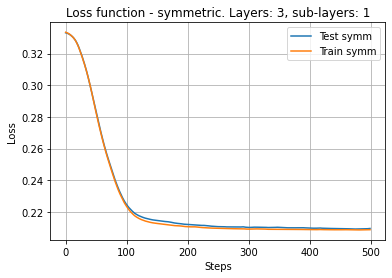

In [138]:
max_epoch = 500

test_cost_symm = np.load(data_folder+'/test_cost.npy', )
train_cost_symm = np.load(data_folder+'/train_cost.npy', )

plt.plot(test_cost_symm[:max_epoch], label='Test symm')
plt.plot(train_cost_symm[:max_epoch], label='Train symm')#
plt.title(f'Loss function - symmetric. Layers: {layers}, sub-layers: {sublayers}')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.legend()

plt.savefig(data_folder+'/loss_symm.pdf') 

plt.show()

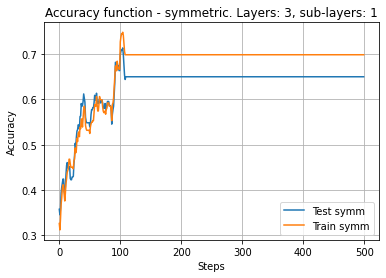

In [140]:
max_epoch = 500

test_accs_symm = np.load(data_folder+'/test_accs.npy', )
train_accs_symm = np.load(data_folder+'/train_accs.npy', )

plt.plot(test_accs_symm[:max_epoch], label='Test symm')
plt.plot(train_accs_symm[:max_epoch], label='Train symm')
plt.title(f'Accuracy function - symmetric. Layers: {layers}, sub-layers: {sublayers}')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.grid()
plt.legend()

plt.savefig(data_folder+'/accs_symm.pdf') 

plt.show()

# Comparison between symmetric - partially simmetric - random models

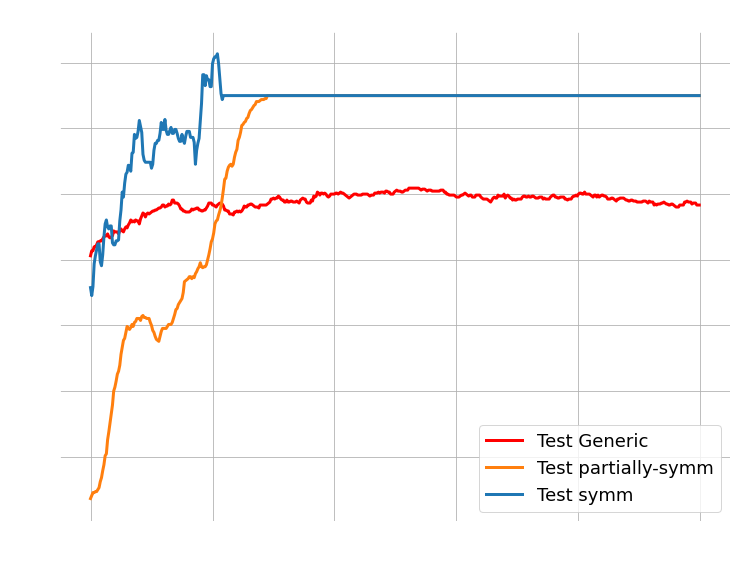

In [2]:
max_epoch = 500

dir_path = '.'
data_folder_symm = dir_path+f'/symmetric/{layers}l-{sublayers}p' 
data_folder_part_symm = dir_path+f'/partially_symmetric/{layers}l-{sublayers}p' 
data_folder_random = dir_path+f'/random/{layers}l-{sublayers}p' 

fig, ax = plt.subplots(figsize=(12, 9))

w = 'white'
plt.title(f'Accuracy - Layers: {layers}, sub-layers: {sublayers}', c=w, fontsize=25 )

test_accs_nonsymm =np.load(data_folder_random+'/test_accs.npy', )
plt.plot(test_accs_nonsymm[:max_epoch], label='Test Generic',color='r', linewidth=3)

test_accs_nonsymm = np.load(data_folder_part_symm+'/test_accs.npy')
plt.plot(test_accs_nonsymm[:max_epoch], label='Test partially-symm', linewidth=3, c='#ff7f0e')

test_accs =np.load(data_folder_symm+'/test_accs.npy', )
plt.plot(test_accs[:max_epoch], label='Test symm', linewidth=3, c='#1f77b4')

plt.xlabel('Steps', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.legend( fontsize=18)
plt.grid()

ax.spines['bottom'].set_color(w)
ax.spines['top'].set_color(w)
ax.spines['left'].set_color(w)
ax.spines['right'].set_color(w)
ax.xaxis.label.set_color(w)
ax.yaxis.label.set_color(w)
ax.tick_params(axis='x', colors=w, labelsize=15 )
ax.tick_params(axis='y', colors=w, labelsize=15)

plt.savefig("comparison_accs.png", ) 

plt.show()


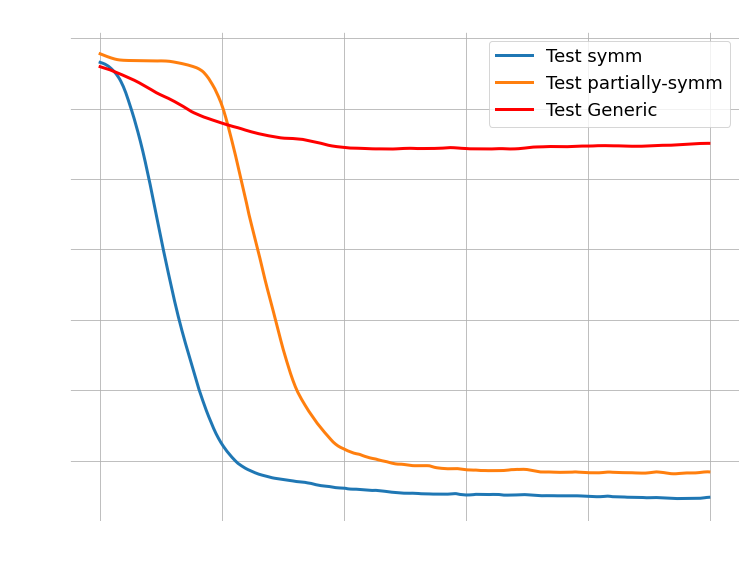

In [3]:
max_epoch = 500

dir_path = '.'
data_folder_symm = dir_path+f'/symmetric/{layers}l-{sublayers}p' 
data_folder_part_symm = dir_path+f'/partially_symmetric/{layers}l-{sublayers}p' 
data_folder_random = dir_path+f'/random/{layers}l-{sublayers}p' 

fig, ax = plt.subplots(figsize=(12, 9))
w='white'
plt.title(f'Loss - Layers: {layers}, sub-layers: {sublayers}', fontsize=25, c=w)
test_cost =np.load(data_folder_symm+'/test_cost.npy', )
plt.plot(test_cost[:max_epoch], label='Test symm',linewidth=3)

test_cost_nonsymm = np.load(data_folder_part_symm+'/test_cost.npy', )
plt.plot(test_cost_nonsymm[:max_epoch], label='Test partially-symm',linewidth=3)

test_cost_nonsymm =np.load(data_folder_random+'/test_cost.npy', )
plt.plot(test_cost_nonsymm[:max_epoch], label='Test Generic',color='r',linewidth=3)

plt.xlabel('Steps', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(fontsize=18)
plt.grid()

ax.spines['bottom'].set_color(w)
ax.spines['top'].set_color(w)
ax.spines['left'].set_color(w)
ax.spines['right'].set_color(w)
ax.xaxis.label.set_color(w)
ax.yaxis.label.set_color(w)
ax.tick_params(axis='x', colors=w, labelsize=15)
ax.tick_params(axis='y', colors=w, labelsize=15)

plt.savefig("comparison_cost.png") 

plt.show()

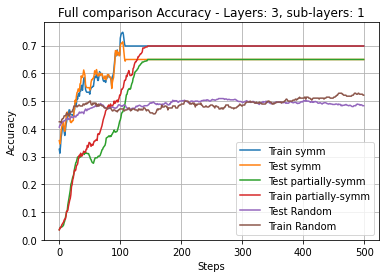

In [143]:
max_epoch = 500

plt.title(f'Full comparison Accuracy - Layers: {layers}, sub-layers: {sublayers}')
test_accs =np.load(data_folder_symm+'/test_accs.npy', )
train_accs =np.load(data_folder_symm+'/train_accs.npy', )
plt.plot(train_accs[:max_epoch], label='Train symm')
plt.plot(test_accs[:max_epoch], label='Test symm')

test_accs_nonsymm = np.load(data_folder_part_symm+'/test_accs.npy', )
train_accs_nonsymm = np.load(data_folder_part_symm+'/train_accs.npy', )
plt.plot(test_accs_nonsymm[:max_epoch], label='Test partially-symm')
plt.plot(train_accs_nonsymm[:max_epoch], label='Train partially-symm')

test_accs_nonsymm =np.load(data_folder_random+'/test_accs.npy', )
train_accs_nonsymm =np.load(data_folder_random+'/train_accs.npy', )
plt.plot(test_accs_nonsymm[:max_epoch], label='Test Random')
plt.plot(train_accs_nonsymm[:max_epoch], label='Train Random')

plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig('full_comparison_accs.pdf')

plt.show()


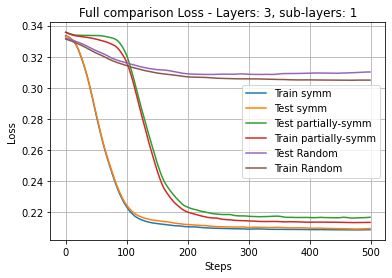

In [144]:
max_epoch = 500

plt.title(f'Full comparison Loss - Layers: {layers}, sub-layers: {sublayers}')
test_cost =np.load(data_folder_symm+'/test_cost.npy', )
train_cost =np.load(data_folder_symm+'/train_cost.npy', )
plt.plot(train_cost[:max_epoch], label='Train symm')
plt.plot(test_cost[:max_epoch], label='Test symm')

test_cost_nonsymm = np.load(data_folder_part_symm+'/test_cost.npy', )
train_cost_nonsymm = np.load(data_folder_part_symm+'/train_cost.npy', )
plt.plot(test_cost_nonsymm[:max_epoch], label='Test partially-symm')
plt.plot(train_cost_nonsymm[:max_epoch], label='Train partially-symm')

test_cost_nonsymm =np.load(data_folder_random+'/test_cost.npy', )
train_cost_nonsymm =np.load(data_folder_random+'/train_cost.npy', )
plt.plot(test_cost_nonsymm[:max_epoch], label='Test Random')
plt.plot(train_cost_nonsymm[:max_epoch], label='Train Random')

plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.savefig('full_comparison_cost.pdf')

plt.show()
